<a href="https://colab.research.google.com/github/trndnhan/Facial-Deepfake-Detection-with-ViT-and-ResNet50/blob/main/Thesis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library install & import

In [ ]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import random
from PIL import Image
from transformers import AutoImageProcessor, ViTForImageClassification, Trainer, TrainingArguments, TrainerCallback, ResNetForImageClassification
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from torch.utils.data import DataLoader
import torch
import transformers
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from peft import LoraConfig, get_peft_model
import psutil

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Data exploration

In [ ]:
def count_files_in_subfolders(base_folder):
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    for subfolder in subfolders:
        num_files = len(os.listdir(subfolder))
        print(f"Folder {subfolder} contains {num_files} files")

In [ ]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/CurrentTrainingData/real')

Folder /content/drive/MyDrive/Work/Thesis/CurrentTrainingData/real/subdataset_35 contains 1000 files


In [ ]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/CurrentTrainingData/fake')

Folder /content/drive/MyDrive/Work/Thesis/CurrentTrainingData/fake/subdataset_35 contains 1000 files


In [ ]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/Data/train/real')

Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_1 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_2 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_3 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_4 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_5 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_6 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_7 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_8 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_9 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_10 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/real/subdataset_11 contains 1000 fil

In [ ]:
count_files_in_subfolders('/content/drive/MyDrive/Work/Thesis/Data/train/fake')

Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_1 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_2 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_3 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_4 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_5 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_6 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_7 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_8 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_9 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_10 contains 1000 files
Folder /content/drive/MyDrive/Work/Thesis/Data/train/fake/subdataset_11 contains 1000 fil

In [ ]:
def load_sample_images(base_folder, num_images=4):
    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]
    sample_images = []

    for subfolder in subfolders:
        images = [os.path.join(subfolder, img) for img in os.listdir(subfolder) if img.endswith(('png', 'jpg', 'jpeg'))]
        random.shuffle(images)
        sample_images.extend(images[:num_images])
        if len(sample_images) >= num_images:
            break

    return sample_images[:num_images]

def display_images(images, labels):
    plt.figure(figsize=(12, 6))
    for i, (img_path, label) in enumerate(zip(images, labels)):
        img = Image.open(img_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

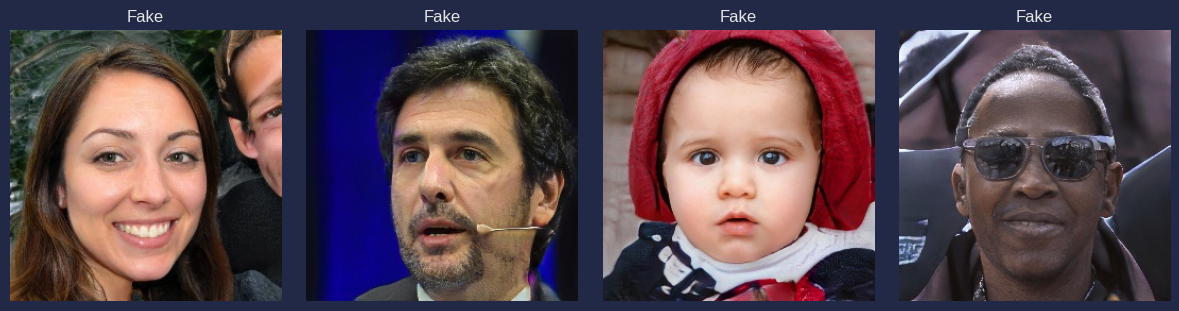

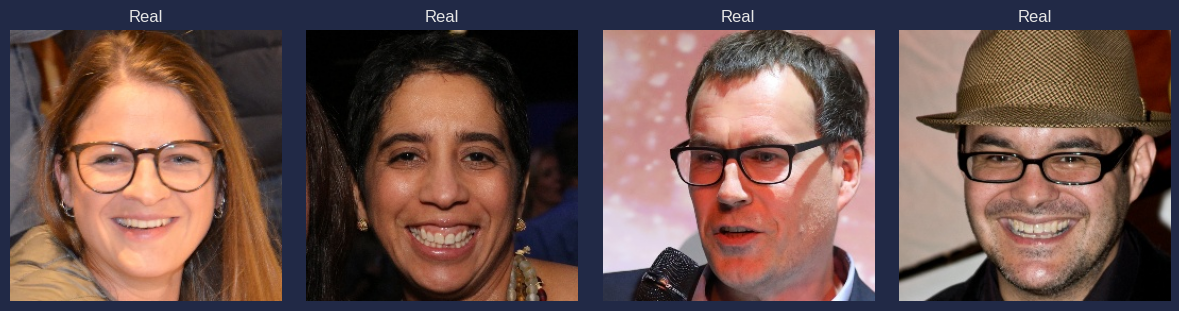

In [ ]:
# Define base folders for fake and real data
base_folder_fake = '/content/drive/MyDrive/Work/Thesis/Data/fake'
base_folder_real = '/content/drive/MyDrive/Work/Thesis/Data/real'

# Load sample images
fake_images = load_sample_images(base_folder_fake, num_images=4)
real_images = load_sample_images(base_folder_real, num_images=4)

# Display images
display_images(fake_images, ['Fake'] * len(fake_images))
display_images(real_images, ['Real'] * len(real_images))

# Data preprocessing & augmentation

In [ ]:
base_vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_model  = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
vit_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-st

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
base_rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=2, ignore_mismatched_sizes=True)
rn_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
rn_processor

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [ ]:
# Shared augmentation pipeline
augmentation_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Color jitter
])

# Define the combined transform for ViT
train_vit_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_vit_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: vit_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

# Define the combined transform for ResNet
train_resnet_combined_transforms = transforms.Compose([
    augmentation_pipeline,  # Apply augmentations
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

val_test_resnet_combined_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: rn_processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0))
])

In [ ]:
# Load the dataset
dataset = ImageFolder(root='/content/drive/MyDrive/Work/Thesis/CurrentTrainingData')

In [ ]:
print(f"Training set size: {len(dataset)}")

Training set size: 2000


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.transform:
            img = self.transform(img)
        return {"pixel_values": img, "labels": label}

# Wrap the datasets with the appropriate transforms
vit_train_dataset = CustomDataset(dataset, transform=train_vit_combined_transforms)

# Wrap the datasets with the appropriate transforms
rn_train_dataset = CustomDataset(dataset, transform=train_resnet_combined_transforms)

# Data after preprocessing

In [ ]:
def collect_images(dataset, num_images=4):
    fake_images = []
    real_images = []
    labels_dict = {0: 'fake', 1: 'real'}

    while len(fake_images) < num_images or len(real_images) < num_images:
        for i in range(len(dataset)):
            sample = dataset[i]
            img = sample["pixel_values"]
            label = sample["labels"]
            if label == 0 and len(fake_images) < num_images:
                fake_images.append((img, labels_dict[0]))
            elif label == 1 and len(real_images) < num_images:
                real_images.append((img, labels_dict[1]))
            if len(fake_images) >= num_images and len(real_images) >= num_images:
                break

    return fake_images, real_images

def visualize_fake_real_images(dataset, num_images=4):
    fake_images, real_images = collect_images(dataset, num_images)

    # Plot
    plt.figure(figsize=(12, 6))

    for i, (img, label) in enumerate(fake_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(label, fontsize=12)
        plt.axis('off')

    for i, (img, label) in enumerate(real_images):
        plt.subplot(2, 4, i + 5)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(label, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

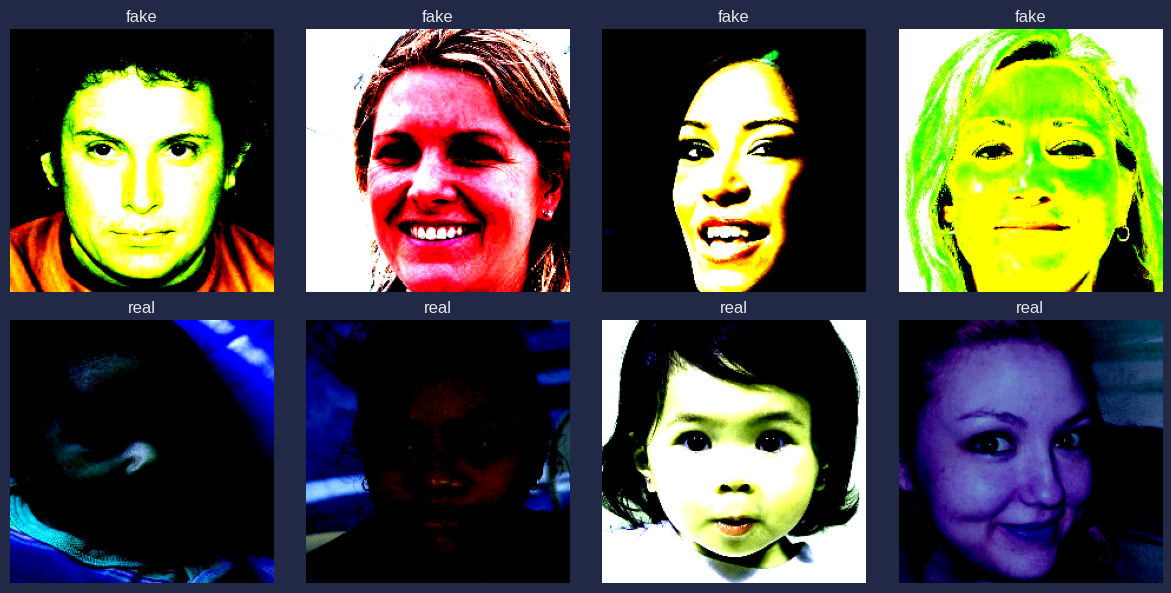

In [ ]:
visualize_fake_real_images(rn_train_dataset, num_images=4)

# Model overview

In [ ]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
rn_model

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
def count_trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad and param.numel() > 10000:
            print(f"Layer: {name} | Trainable parameters: {param.numel()}")

In [ ]:
print_trainable_parameters(vit_model)

trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [ ]:
print_trainable_parameters(rn_model)

trainable params: 23512130 || all params: 23512130 || trainable%: 100.00


In [ ]:
count_trainable_parameters(vit_model)

Layer: vit.embeddings.position_embeddings | Trainable parameters: 151296
Layer: vit.embeddings.patch_embeddings.projection.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.attention.output.dense.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.0.intermediate.dense.weight | Trainable parameters: 2359296
Layer: vit.encoder.layer.0.output.dense.weight | Trainable parameters: 2359296
Layer: vit.encoder.layer.1.attention.attention.query.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.attention.key.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.attention.value.weight | Trainable parameters: 589824
Layer: vit.encoder.layer.1.attention.output.d

In [ ]:
count_trainable_parameters(rn_model)

Layer: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.0.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.0.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.1.layer.0.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.1.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.1.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.2.layer.0.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.0.layers.2.layer.1.convolution.weight | Trainable parameters: 36864
Layer: resnet.encoder.stages.0.layers.2.layer.2.convolution.weight | Trainable parameters: 16384
Layer: resnet.encoder.stages.1.layers.0.shortcut.convolution.weight | Trainable parameters: 131072
Layer: resnet.encoder.stage

In [ ]:
# Freeze every layer but the last layer
for param in vit_model.parameters():
    param.requires_grad = False
for param in rn_model.parameters():
    param.requires_grad = False
for param in base_vit_model.parameters():
    param.requires_grad = False
for param in base_rn_model.parameters():
    param.requires_grad = False

# Unfreeze the last layer of the base models
for param in base_vit_model.classifier.parameters():
    param.requires_grad = True
for param in base_rn_model.classifier.parameters():
    param.requires_grad = True

In [ ]:
vit_config = LoraConfig(
    r=1,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "layer.8.attention.attention.query",
        "layer.8.attention.attention.key",
        "layer.8.attention.attention.value"
        "layer.9.attention.attention.query",
        "layer.9.attention.attention.key",
        "layer.9.attention.attention.value",
        "layer.10.attention.attention.query",
        "layer.10.attention.attention.key",
        "layer.10.attention.attention.value",
        "layer.11.attention.attention.query",
        "layer.11.attention.attention.key",
        "layer.11.attention.attention.value"
    ]
)

rn_config = LoraConfig(
    r=1,
    lora_alpha=16,
    lora_dropout=0.1,
    modules_to_save=["classifier"],
    target_modules=[
        "layer.1.convolution"
    ]
)

vit_lora_model = get_peft_model(vit_model, vit_config)
rn_lora_model = get_peft_model(rn_model, rn_config)

In [ ]:
print_trainable_parameters(vit_lora_model)

trainable params: 16898 || all params: 85817092 || trainable%: 0.02


In [ ]:
print_trainable_parameters(rn_lora_model)

trainable params: 41858 || all params: 23553988 || trainable%: 0.18


In [ ]:
print_trainable_parameters(base_vit_model)

trainable params: 1538 || all params: 85800194 || trainable%: 0.00


In [ ]:
print_trainable_parameters(base_rn_model)

trainable params: 4098 || all params: 23512130 || trainable%: 0.02


# Prepare Trainer

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
class CustomTrainer(transformers.Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_predictions = []
        self.epoch_labels = []
        self.epoch_loss = []

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        MAX: Subclassed to compute training accuracy.

        How the loss is computed by Trainer. By default, all models return the loss in
        the first element.

        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)

        if "labels" in inputs:
            preds = outputs.logits.detach()

            # Store predictions and labels for epoch-level metrics
            self.epoch_predictions.append(preds.cpu().numpy())
            self.epoch_labels.append(inputs["labels"].cpu().numpy())

        # Save past state if it exists
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            self.epoch_loss.append(loss.item())  # Store loss for epoch-level metrics

        return (loss, outputs) if return_outputs else loss

In [ ]:
class CustomCallback(TrainerCallback):

    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        # Aggregate predictions and labels for the entire epoch
        epoch_predictions = np.concatenate(self._trainer.epoch_predictions)
        epoch_labels = np.concatenate(self._trainer.epoch_labels)

        # Compute accuracy
        accuracy = np.mean(epoch_predictions.argmax(axis=1) == epoch_labels)

        # Compute mean loss
        mean_loss = np.mean(self._trainer.epoch_loss)

        # Compute precision, recall, and F1-score
        precision, recall, f1, _ = precision_recall_fscore_support(
            epoch_labels, epoch_predictions.argmax(axis=1), average="weighted"
        )

        # Print epoch-level metrics
        print(f"Accuracy: {accuracy:.4f}, Loss: {mean_loss:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        # Print memory usage
        process = psutil.Process()
        cpu_memory = process.memory_info().rss / (1024 ** 3)  # GB
        print(f"CPU memory usage: {cpu_memory:.2f} GB")

        # Clear stored predictions, labels, and loss for the next epoch
        self._trainer.epoch_predictions = []
        self._trainer.epoch_labels = []
        self._trainer.epoch_loss = []

        return None

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=1,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=1,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

# Training

## Training first subfolder (0.025 epoch)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train()

Step,Training Loss


Accuracy: 0.5490, Loss: 0.6859
Precision: 0.5916, Recall: 0.5490, F1: 0.4897
CPU memory usage: 1.48 GB


TrainOutput(global_step=40, training_loss=0.6859185695648193, metrics={'train_runtime': 938.9016, 'train_samples_per_second': 2.13, 'train_steps_per_second': 0.043, 'total_flos': 4.247080685568e+16, 'train_loss': 0.6859185695648193, 'epoch': 1.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train()

Step,Training Loss


Accuracy: 0.5215, Loss: 0.7186
Precision: 0.5222, Recall: 0.5215, F1: 0.5178
CPU memory usage: 3.00 GB


TrainOutput(global_step=40, training_loss=0.7185947895050049, metrics={'train_runtime': 1424.3228, 'train_samples_per_second': 1.404, 'train_steps_per_second': 0.028, 'total_flos': 1.54983979229184e+17, 'train_loss': 0.7185947895050049, 'epoch': 1.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train()

Step,Training Loss


Accuracy: 0.5225, Loss: 0.6920
Precision: 0.5455, Recall: 0.5225, F1: 0.4534
CPU memory usage: 2.68 GB


TrainOutput(global_step=40, training_loss=0.6920181751251221, metrics={'train_runtime': 1969.1859, 'train_samples_per_second': 1.016, 'train_steps_per_second': 0.02, 'total_flos': 4.2546416467968e+16, 'train_loss': 0.6920181751251221, 'epoch': 1.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train()

Step,Training Loss


Accuracy: 0.5460, Loss: 0.7185
Precision: 0.5598, Recall: 0.5460, F1: 0.5183
CPU memory usage: 4.53 GB


TrainOutput(global_step=40, training_loss=0.7184763431549073, metrics={'train_runtime': 1968.0411, 'train_samples_per_second': 1.016, 'train_steps_per_second': 0.02, 'total_flos': 1.55014502694912e+17, 'train_loss': 0.7184763431549073, 'epoch': 1.0})

##Training second subfolder (0.05 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=2,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=2,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5670, Loss: 0.6848
Precision: 0.6193, Recall: 0.5670, F1: 0.5137
CPU memory usage: 4.31 GB


TrainOutput(global_step=80, training_loss=0.34239802360534666, metrics={'train_runtime': 553.3389, 'train_samples_per_second': 7.229, 'train_steps_per_second': 0.145, 'total_flos': 8.494161371136e+16, 'train_loss': 0.34239802360534666, 'epoch': 2.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5305, Loss: 0.7241
Precision: 0.5324, Recall: 0.5305, F1: 0.5236
CPU memory usage: 4.37 GB


TrainOutput(global_step=80, training_loss=0.3620391607284546, metrics={'train_runtime': 1437.8414, 'train_samples_per_second': 2.782, 'train_steps_per_second': 0.056, 'total_flos': 3.09967958458368e+17, 'train_loss': 0.3620391607284546, 'epoch': 2.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5090, Loss: 0.6921
Precision: 0.5174, Recall: 0.5090, F1: 0.4418
CPU memory usage: 4.37 GB


TrainOutput(global_step=80, training_loss=0.34605860710144043, metrics={'train_runtime': 1315.6363, 'train_samples_per_second': 3.04, 'train_steps_per_second': 0.061, 'total_flos': 8.5092832935936e+16, 'train_loss': 0.34605860710144043, 'epoch': 2.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-1')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5490, Loss: 0.7039
Precision: 0.5539, Recall: 0.5490, F1: 0.5385
CPU memory usage: 4.99 GB


TrainOutput(global_step=80, training_loss=0.35194251537322996, metrics={'train_runtime': 2347.4005, 'train_samples_per_second': 1.704, 'train_steps_per_second': 0.034, 'total_flos': 3.10029005389824e+17, 'train_loss': 0.35194251537322996, 'epoch': 2.0})

##Training third subfolder (0.075 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=3,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5740, Loss: 0.6838
Precision: 0.6174, Recall: 0.5740, F1: 0.5306
CPU memory usage: 4.31 GB


TrainOutput(global_step=120, training_loss=0.22794539133707684, metrics={'train_runtime': 919.5411, 'train_samples_per_second': 6.525, 'train_steps_per_second': 0.13, 'total_flos': 1.2741242056704e+17, 'train_loss': 0.22794539133707684, 'epoch': 3.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5400, Loss: 0.7037
Precision: 0.5419, Recall: 0.5400, F1: 0.5348
CPU memory usage: 2.00 GB


TrainOutput(global_step=120, training_loss=0.23457024892171224, metrics={'train_runtime': 1810.4837, 'train_samples_per_second': 3.314, 'train_steps_per_second': 0.066, 'total_flos': 4.64951937687552e+17, 'train_loss': 0.23457024892171224, 'epoch': 3.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5125, Loss: 0.6902
Precision: 0.5226, Recall: 0.5125, F1: 0.4511
CPU memory usage: 6.26 GB


TrainOutput(global_step=120, training_loss=0.23005019823710124, metrics={'train_runtime': 1570.0815, 'train_samples_per_second': 3.821, 'train_steps_per_second': 0.076, 'total_flos': 1.27639249403904e+17, 'train_loss': 0.23005019823710124, 'epoch': 3.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-2')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5935, Loss: 0.6733
Precision: 0.5946, Recall: 0.5935, F1: 0.5923
CPU memory usage: 6.92 GB


TrainOutput(global_step=120, training_loss=0.22441884676615398, metrics={'train_runtime': 2101.8367, 'train_samples_per_second': 2.855, 'train_steps_per_second': 0.057, 'total_flos': 4.65043508084736e+17, 'train_loss': 0.22441884676615398, 'epoch': 3.0})

##Training fourth subfolder (0.1 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=4,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5795, Loss: 0.6833
Precision: 0.6200, Recall: 0.5795, F1: 0.5407
CPU memory usage: 1.28 GB


TrainOutput(global_step=160, training_loss=0.17083740234375, metrics={'train_runtime': 1012.6191, 'train_samples_per_second': 7.9, 'train_steps_per_second': 0.158, 'total_flos': 1.6988322742272e+17, 'train_loss': 0.17083740234375, 'epoch': 4.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5550, Loss: 0.6971
Precision: 0.5568, Recall: 0.5550, F1: 0.5515
CPU memory usage: 4.64 GB


TrainOutput(global_step=160, training_loss=0.1742812752723694, metrics={'train_runtime': 1401.4259, 'train_samples_per_second': 5.708, 'train_steps_per_second': 0.114, 'total_flos': 6.19935916916736e+17, 'train_loss': 0.1742812752723694, 'epoch': 4.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5440, Loss: 0.6894
Precision: 0.5780, Recall: 0.5440, F1: 0.4883
CPU memory usage: 4.84 GB


TrainOutput(global_step=160, training_loss=0.17235071659088136, metrics={'train_runtime': 1307.3677, 'train_samples_per_second': 6.119, 'train_steps_per_second': 0.122, 'total_flos': 1.70185665871872e+17, 'train_loss': 0.17235071659088136, 'epoch': 4.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-3')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5995, Loss: 0.6643
Precision: 0.5996, Recall: 0.5995, F1: 0.5994
CPU memory usage: 4.15 GB


TrainOutput(global_step=160, training_loss=0.16607903242111205, metrics={'train_runtime': 2434.8418, 'train_samples_per_second': 3.286, 'train_steps_per_second': 0.066, 'total_flos': 6.20058010779648e+17, 'train_loss': 0.16607903242111205, 'epoch': 4.0})

##Training fifth subfolder (0.125 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=5,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5950, Loss: 0.6824
Precision: 0.6384, Recall: 0.5950, F1: 0.5605
CPU memory usage: 1.22 GB


TrainOutput(global_step=200, training_loss=0.13647119522094728, metrics={'train_runtime': 1047.6501, 'train_samples_per_second': 9.545, 'train_steps_per_second': 0.191, 'total_flos': 2.123540342784e+17, 'train_loss': 0.13647119522094728, 'epoch': 5.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5525, Loss: 0.7013
Precision: 0.5549, Recall: 0.5525, F1: 0.5476
CPU memory usage: 3.01 GB


TrainOutput(global_step=200, training_loss=0.14025315284729004, metrics={'train_runtime': 1231.5001, 'train_samples_per_second': 8.12, 'train_steps_per_second': 0.162, 'total_flos': 7.7491989614592e+17, 'train_loss': 0.14025315284729004, 'epoch': 5.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5385, Loss: 0.6891
Precision: 0.5598, Recall: 0.5385, F1: 0.4934
CPU memory usage: 2.69 GB


TrainOutput(global_step=200, training_loss=0.13781007766723632, metrics={'train_runtime': 1315.4488, 'train_samples_per_second': 7.602, 'train_steps_per_second': 0.152, 'total_flos': 2.1273208233984e+17, 'train_loss': 0.13781007766723632, 'epoch': 5.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-4')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6030, Loss: 0.6676
Precision: 0.6030, Recall: 0.6030, F1: 0.6030
CPU memory usage: 4.92 GB


TrainOutput(global_step=200, training_loss=0.1335196590423584, metrics={'train_runtime': 1747.8204, 'train_samples_per_second': 5.721, 'train_steps_per_second': 0.114, 'total_flos': 7.7507251347456e+17, 'train_loss': 0.1335196590423584, 'epoch': 5.0})

##Training sixth subfolder (0.15 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=6,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=6,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5855, Loss: 0.6823
Precision: 0.6224, Recall: 0.5855, F1: 0.5517
CPU memory usage: 1.44 GB


TrainOutput(global_step=240, training_loss=0.11371860504150391, metrics={'train_runtime': 1267.7795, 'train_samples_per_second': 9.465, 'train_steps_per_second': 0.189, 'total_flos': 2.5482484113408e+17, 'train_loss': 0.11371860504150391, 'epoch': 6.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5655, Loss: 0.6903
Precision: 0.5681, Recall: 0.5655, F1: 0.5613
CPU memory usage: 5.25 GB


TrainOutput(global_step=240, training_loss=0.11505028406778971, metrics={'train_runtime': 1331.8321, 'train_samples_per_second': 9.01, 'train_steps_per_second': 0.18, 'total_flos': 9.29903875375104e+17, 'train_loss': 0.11505028406778971, 'epoch': 6.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5530, Loss: 0.6882
Precision: 0.5906, Recall: 0.5530, F1: 0.5013
CPU memory usage: 4.85 GB


TrainOutput(global_step=240, training_loss=0.11469479401906331, metrics={'train_runtime': 1458.714, 'train_samples_per_second': 8.226, 'train_steps_per_second': 0.165, 'total_flos': 2.55278498807808e+17, 'train_loss': 0.11469479401906331, 'epoch': 6.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-5')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6175, Loss: 0.6563
Precision: 0.6178, Recall: 0.6175, F1: 0.6172
CPU memory usage: 7.78 GB


TrainOutput(global_step=240, training_loss=0.10938201745351156, metrics={'train_runtime': 1706.5987, 'train_samples_per_second': 7.032, 'train_steps_per_second': 0.141, 'total_flos': 9.30087016169472e+17, 'train_loss': 0.10938201745351156, 'epoch': 6.0})

##Training seventh subfolder (0.175 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=7,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=7,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5860, Loss: 0.6838
Precision: 0.6237, Recall: 0.5860, F1: 0.5519
CPU memory usage: 1.36 GB


TrainOutput(global_step=280, training_loss=0.09768206051417759, metrics={'train_runtime': 791.1273, 'train_samples_per_second': 17.696, 'train_steps_per_second': 0.354, 'total_flos': 2.9729564798976e+17, 'train_loss': 0.09768206051417759, 'epoch': 7.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5655, Loss: 0.6847
Precision: 0.5685, Recall: 0.5655, F1: 0.5607
CPU memory usage: 1.92 GB


TrainOutput(global_step=280, training_loss=0.09781560897827149, metrics={'train_runtime': 1585.2456, 'train_samples_per_second': 8.831, 'train_steps_per_second': 0.177, 'total_flos': 1.084887854604288e+18, 'train_loss': 0.09781560897827149, 'epoch': 7.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5605, Loss: 0.6871
Precision: 0.5958, Recall: 0.5605, F1: 0.5159
CPU memory usage: 3.08 GB


TrainOutput(global_step=280, training_loss=0.09815809386117118, metrics={'train_runtime': 1405.4806, 'train_samples_per_second': 9.961, 'train_steps_per_second': 0.199, 'total_flos': 2.97824915275776e+17, 'train_loss': 0.09815809386117118, 'epoch': 7.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-6')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6000, Loss: 0.6631
Precision: 0.6000, Recall: 0.6000, F1: 0.6000
CPU memory usage: 5.36 GB


TrainOutput(global_step=280, training_loss=0.09473013196672712, metrics={'train_runtime': 2006.2077, 'train_samples_per_second': 6.978, 'train_steps_per_second': 0.14, 'total_flos': 1.085101518864384e+18, 'train_loss': 0.09473013196672712, 'epoch': 7.0})

##Training eighth subfolder (0.2 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=8,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5990, Loss: 0.6824
Precision: 0.6345, Recall: 0.5990, F1: 0.5706
CPU memory usage: 5.36 GB


TrainOutput(global_step=320, training_loss=0.08529695868492126, metrics={'train_runtime': 840.4679, 'train_samples_per_second': 19.037, 'train_steps_per_second': 0.381, 'total_flos': 3.3976645484544e+17, 'train_loss': 0.08529695868492126, 'epoch': 8.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5670, Loss: 0.6957
Precision: 0.5710, Recall: 0.5670, F1: 0.5609
CPU memory usage: 1.72 GB


TrainOutput(global_step=320, training_loss=0.08696720600128174, metrics={'train_runtime': 1656.827, 'train_samples_per_second': 9.657, 'train_steps_per_second': 0.193, 'total_flos': 1.239871833833472e+18, 'train_loss': 0.08696720600128174, 'epoch': 8.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5415, Loss: 0.6888
Precision: 0.5640, Recall: 0.5415, F1: 0.4973
CPU memory usage: 2.74 GB


TrainOutput(global_step=320, training_loss=0.08610387444496155, metrics={'train_runtime': 1308.4548, 'train_samples_per_second': 12.228, 'train_steps_per_second': 0.245, 'total_flos': 3.40371331743744e+17, 'train_loss': 0.08610387444496155, 'epoch': 8.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-7')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6290, Loss: 0.6528
Precision: 0.6298, Recall: 0.6290, F1: 0.6284
CPU memory usage: 5.37 GB


TrainOutput(global_step=320, training_loss=0.08160330653190613, metrics={'train_runtime': 1700.3293, 'train_samples_per_second': 9.41, 'train_steps_per_second': 0.188, 'total_flos': 1.240116021559296e+18, 'train_loss': 0.08160330653190613, 'epoch': 8.0})

## First evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=8,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=8,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-8')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.71      0.39      0.50      1000
        real       0.58      0.84      0.69      1000

    accuracy                           0.61      2000
   macro avg       0.64      0.61      0.59      2000
weighted avg       0.64      0.61      0.59      2000


Confusion Matrix:
[[388 612]
 [159 841]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-8')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.63      0.60      1000
        real       0.58      0.51      0.54      1000

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000


Confusion Matrix:
[[634 366]
 [494 506]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-8')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.53      0.85      0.66      1000
        real       0.64      0.26      0.37      1000

    accuracy                           0.56      2000
   macro avg       0.58      0.56      0.51      2000
weighted avg       0.58      0.56      0.51      2000


Confusion Matrix:
[[850 150]
 [739 261]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-8')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.63      0.62      1000
        real       0.62      0.61      0.62      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000


Confusion Matrix:
[[630 370]
 [389 611]]


##Training ninth subfolder (0.225 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=9,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=9,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5970, Loss: 0.6832
Precision: 0.6280, Recall: 0.5970, F1: 0.5710
CPU memory usage: 1.47 GB


TrainOutput(global_step=360, training_loss=0.0759073363410102, metrics={'train_runtime': 2009.7863, 'train_samples_per_second': 8.956, 'train_steps_per_second': 0.179, 'total_flos': 3.8223726170112e+17, 'train_loss': 0.0759073363410102, 'epoch': 9.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5930, Loss: 0.6743
Precision: 0.5975, Recall: 0.5930, F1: 0.5883
CPU memory usage: 1.91 GB


TrainOutput(global_step=360, training_loss=0.07492644521925185, metrics={'train_runtime': 1517.6509, 'train_samples_per_second': 11.86, 'train_steps_per_second': 0.237, 'total_flos': 1.394855813062656e+18, 'train_loss': 0.07492644521925185, 'epoch': 9.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5740, Loss: 0.6865
Precision: 0.6078, Recall: 0.5740, F1: 0.5378
CPU memory usage: 3.17 GB


TrainOutput(global_step=360, training_loss=0.07627568774753146, metrics={'train_runtime': 1375.666, 'train_samples_per_second': 13.085, 'train_steps_per_second': 0.262, 'total_flos': 3.82917748211712e+17, 'train_loss': 0.07627568774753146, 'epoch': 9.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-8')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6210, Loss: 0.6543
Precision: 0.6222, Recall: 0.6210, F1: 0.6201
CPU memory usage: 5.27 GB


TrainOutput(global_step=360, training_loss=0.07269598642985026, metrics={'train_runtime': 1927.1728, 'train_samples_per_second': 9.34, 'train_steps_per_second': 0.187, 'total_flos': 1.395130524254208e+18, 'train_loss': 0.07269598642985026, 'epoch': 9.0})

##Training tenth subfolder (0.25 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=10,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5830, Loss: 0.6839
Precision: 0.6078, Recall: 0.5830, F1: 0.5575
CPU memory usage: 5.09 GB


TrainOutput(global_step=400, training_loss=0.06838658332824707, metrics={'train_runtime': 1794.8131, 'train_samples_per_second': 11.143, 'train_steps_per_second': 0.223, 'total_flos': 4.247080685568e+17, 'train_loss': 0.06838658332824707, 'epoch': 10.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5835, Loss: 0.6783
Precision: 0.5870, Recall: 0.5835, F1: 0.5793
CPU memory usage: 4.49 GB


TrainOutput(global_step=400, training_loss=0.06783483505249023, metrics={'train_runtime': 1403.8843, 'train_samples_per_second': 14.246, 'train_steps_per_second': 0.285, 'total_flos': 1.54983979229184e+18, 'train_loss': 0.06783483505249023, 'epoch': 10.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5555, Loss: 0.6879
Precision: 0.5775, Recall: 0.5555, F1: 0.5215
CPU memory usage: 4.52 GB


TrainOutput(global_step=400, training_loss=0.06879109382629395, metrics={'train_runtime': 1284.4222, 'train_samples_per_second': 15.571, 'train_steps_per_second': 0.311, 'total_flos': 4.2546416467968e+17, 'train_loss': 0.06879109382629395, 'epoch': 10.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-9')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6195, Loss: 0.6523
Precision: 0.6227, Recall: 0.6195, F1: 0.6170
CPU memory usage: 4.43 GB


TrainOutput(global_step=400, training_loss=0.06523365497589112, metrics={'train_runtime': 1937.5462, 'train_samples_per_second': 10.322, 'train_steps_per_second': 0.206, 'total_flos': 1.55014502694912e+18, 'train_loss': 0.06523365497589112, 'epoch': 10.0})

##Training eleventh subfolder (0.275 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=11,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=11,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5925, Loss: 0.6831
Precision: 0.6189, Recall: 0.5925, F1: 0.5686
CPU memory usage: 1.38 GB


TrainOutput(global_step=440, training_loss=0.06210248253562234, metrics={'train_runtime': 1255.1258, 'train_samples_per_second': 17.528, 'train_steps_per_second': 0.351, 'total_flos': 4.6717887541248e+17, 'train_loss': 0.06210248253562234, 'epoch': 11.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5820, Loss: 0.6730
Precision: 0.5863, Recall: 0.5820, F1: 0.5767
CPU memory usage: 1.87 GB


TrainOutput(global_step=440, training_loss=0.061181215806440876, metrics={'train_runtime': 1614.2039, 'train_samples_per_second': 13.629, 'train_steps_per_second': 0.273, 'total_flos': 1.704823771521024e+18, 'train_loss': 0.061181215806440876, 'epoch': 11.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5615, Loss: 0.6877
Precision: 0.5903, Recall: 0.5615, F1: 0.5235
CPU memory usage: 2.74 GB


TrainOutput(global_step=440, training_loss=0.0625190561467951, metrics={'train_runtime': 1650.4914, 'train_samples_per_second': 13.329, 'train_steps_per_second': 0.267, 'total_flos': 4.68010581147648e+17, 'train_loss': 0.0625190561467951, 'epoch': 11.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-10')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6260, Loss: 0.6494
Precision: 0.6269, Recall: 0.6260, F1: 0.6254
CPU memory usage: 4.62 GB


TrainOutput(global_step=440, training_loss=0.05903199369257146, metrics={'train_runtime': 1691.158, 'train_samples_per_second': 13.009, 'train_steps_per_second': 0.26, 'total_flos': 1.705159529644032e+18, 'train_loss': 0.05903199369257146, 'epoch': 11.0})

##Training twelfth subfolder (0.3 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=12,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=12,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6035, Loss: 0.6825
Precision: 0.6421, Recall: 0.6035, F1: 0.5746
CPU memory usage: 1.43 GB


TrainOutput(global_step=480, training_loss=0.056878785292307533, metrics={'train_runtime': 1572.4314, 'train_samples_per_second': 15.263, 'train_steps_per_second': 0.305, 'total_flos': 5.0964968226816e+17, 'train_loss': 0.056878785292307533, 'epoch': 12.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5850, Loss: 0.6690
Precision: 0.5899, Recall: 0.5850, F1: 0.5792
CPU memory usage: 1.86 GB


TrainOutput(global_step=480, training_loss=0.05575118859608968, metrics={'train_runtime': 1596.7175, 'train_samples_per_second': 15.031, 'train_steps_per_second': 0.301, 'total_flos': 1.859807750750208e+18, 'train_loss': 0.05575118859608968, 'epoch': 12.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5695, Loss: 0.6873
Precision: 0.6031, Recall: 0.5695, F1: 0.5313
CPU memory usage: 3.10 GB


TrainOutput(global_step=480, training_loss=0.05727569262186686, metrics={'train_runtime': 1467.4954, 'train_samples_per_second': 16.354, 'train_steps_per_second': 0.327, 'total_flos': 5.10556997615616e+17, 'train_loss': 0.05727569262186686, 'epoch': 12.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-11')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6110, Loss: 0.6567
Precision: 0.6119, Recall: 0.6110, F1: 0.6102
CPU memory usage: 5.03 GB


TrainOutput(global_step=480, training_loss=0.05472585360209147, metrics={'train_runtime': 2005.3133, 'train_samples_per_second': 11.968, 'train_steps_per_second': 0.239, 'total_flos': 1.860174032338944e+18, 'train_loss': 0.05472585360209147, 'epoch': 12.0})

##Training thirteenth subfolder (0.325 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=13,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=13,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
500,0.684700


Accuracy: 0.5830, Loss: 0.6829
Precision: 0.6073, Recall: 0.5830, F1: 0.5580
CPU memory usage: 1.51 GB


TrainOutput(global_step=520, training_loss=0.05253292413858267, metrics={'train_runtime': 1250.7676, 'train_samples_per_second': 20.787, 'train_steps_per_second': 0.416, 'total_flos': 5.5212048912384e+17, 'train_loss': 0.05253292413858267, 'epoch': 13.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
500,0.679800


Accuracy: 0.5810, Loss: 0.6805
Precision: 0.5842, Recall: 0.5810, F1: 0.5769
CPU memory usage: 1.92 GB


TrainOutput(global_step=520, training_loss=0.05234560232896071, metrics={'train_runtime': 1462.2055, 'train_samples_per_second': 17.781, 'train_steps_per_second': 0.356, 'total_flos': 2.014791729979392e+18, 'train_loss': 0.05234560232896071, 'epoch': 13.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
500,0.687300


Accuracy: 0.5490, Loss: 0.6879
Precision: 0.5705, Recall: 0.5490, F1: 0.5118
CPU memory usage: 3.06 GB


TrainOutput(global_step=520, training_loss=0.052912028019244856, metrics={'train_runtime': 1399.9831, 'train_samples_per_second': 18.572, 'train_steps_per_second': 0.371, 'total_flos': 5.53103414083584e+17, 'train_loss': 0.052912028019244856, 'epoch': 13.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-12')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
500,0.645000


Accuracy: 0.6405, Loss: 0.6411
Precision: 0.6427, Recall: 0.6405, F1: 0.6391
CPU memory usage: 5.24 GB


TrainOutput(global_step=520, training_loss=0.04931541222792405, metrics={'train_runtime': 1721.9506, 'train_samples_per_second': 15.099, 'train_steps_per_second': 0.302, 'total_flos': 2.015188535033856e+18, 'train_loss': 0.04931541222792405, 'epoch': 13.0})

##Training fourteenth subfolder (0.35 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=14,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=14,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5920, Loss: 0.6826
Precision: 0.6172, Recall: 0.5920, F1: 0.5688
CPU memory usage: 4.99 GB


TrainOutput(global_step=560, training_loss=0.04875843184334891, metrics={'train_runtime': 1196.9609, 'train_samples_per_second': 23.393, 'train_steps_per_second': 0.468, 'total_flos': 5.9459129597952e+17, 'train_loss': 0.04875843184334891, 'epoch': 14.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6095, Loss: 0.6577
Precision: 0.6132, Recall: 0.6095, F1: 0.6063
CPU memory usage: 1.79 GB


TrainOutput(global_step=560, training_loss=0.046978058133806504, metrics={'train_runtime': 2164.9191, 'train_samples_per_second': 12.934, 'train_steps_per_second': 0.259, 'total_flos': 2.169775709208576e+18, 'train_loss': 0.046978058133806504, 'epoch': 14.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5505, Loss: 0.6868
Precision: 0.5718, Recall: 0.5505, F1: 0.5144
CPU memory usage: 3.07 GB


TrainOutput(global_step=560, training_loss=0.04905501093183245, metrics={'train_runtime': 1427.0763, 'train_samples_per_second': 19.621, 'train_steps_per_second': 0.392, 'total_flos': 5.95649830551552e+17, 'train_loss': 0.04905501093183245, 'epoch': 14.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-13')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6385, Loss: 0.6355
Precision: 0.6402, Recall: 0.6385, F1: 0.6374
CPU memory usage: 5.13 GB


TrainOutput(global_step=560, training_loss=0.04539069788796561, metrics={'train_runtime': 1985.0197, 'train_samples_per_second': 14.106, 'train_steps_per_second': 0.282, 'total_flos': 2.170203037728768e+18, 'train_loss': 0.04539069788796561, 'epoch': 14.0})

##Training fifteenth subfolder (0.375 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=15,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=15,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5955, Loss: 0.6822
Precision: 0.6239, Recall: 0.5955, F1: 0.5709
CPU memory usage: 5.22 GB


TrainOutput(global_step=600, training_loss=0.04548086166381836, metrics={'train_runtime': 1223.5313, 'train_samples_per_second': 24.519, 'train_steps_per_second': 0.49, 'total_flos': 6.370621028352e+17, 'train_loss': 0.04548086166381836, 'epoch': 15.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6020, Loss: 0.6695
Precision: 0.6064, Recall: 0.6020, F1: 0.5978
CPU memory usage: 5.19 GB


TrainOutput(global_step=600, training_loss=0.044634459813435876, metrics={'train_runtime': 1415.8567, 'train_samples_per_second': 21.189, 'train_steps_per_second': 0.424, 'total_flos': 2.32475968843776e+18, 'train_loss': 0.044634459813435876, 'epoch': 15.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5515, Loss: 0.6885
Precision: 0.5717, Recall: 0.5515, F1: 0.5175
CPU memory usage: 5.12 GB


TrainOutput(global_step=600, training_loss=0.04589932441711426, metrics={'train_runtime': 1469.083, 'train_samples_per_second': 20.421, 'train_steps_per_second': 0.408, 'total_flos': 6.3819624701952e+17, 'train_loss': 0.04589932441711426, 'epoch': 15.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-14')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6295, Loss: 0.6453
Precision: 0.6314, Recall: 0.6295, F1: 0.6282
CPU memory usage: 6.44 GB


TrainOutput(global_step=600, training_loss=0.04301957130432129, metrics={'train_runtime': 2006.5577, 'train_samples_per_second': 14.951, 'train_steps_per_second': 0.299, 'total_flos': 2.32521754042368e+18, 'train_loss': 0.04301957130432129, 'epoch': 15.0})

##Training sixteenth subfolder (0.4 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=16,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6005, Loss: 0.6819
Precision: 0.6314, Recall: 0.6005, F1: 0.5755
CPU memory usage: 6.44 GB


TrainOutput(global_step=640, training_loss=0.04261850416660309, metrics={'train_runtime': 1239.0416, 'train_samples_per_second': 25.826, 'train_steps_per_second': 0.517, 'total_flos': 6.7953290969088e+17, 'train_loss': 0.04261850416660309, 'epoch': 16.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5915, Loss: 0.6715
Precision: 0.5957, Recall: 0.5915, F1: 0.5870
CPU memory usage: 6.41 GB


TrainOutput(global_step=640, training_loss=0.04197165668010712, metrics={'train_runtime': 1443.7712, 'train_samples_per_second': 22.164, 'train_steps_per_second': 0.443, 'total_flos': 2.479743667666944e+18, 'train_loss': 0.04197165668010712, 'epoch': 16.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5665, Loss: 0.6869
Precision: 0.5974, Recall: 0.5665, F1: 0.5292
CPU memory usage: 2.19 GB


TrainOutput(global_step=640, training_loss=0.04292966425418854, metrics={'train_runtime': 1976.7248, 'train_samples_per_second': 16.188, 'train_steps_per_second': 0.324, 'total_flos': 6.80742663487488e+17, 'train_loss': 0.04292966425418854, 'epoch': 16.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-15')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6345, Loss: 0.6448
Precision: 0.6359, Recall: 0.6345, F1: 0.6335
CPU memory usage: 4.61 GB


TrainOutput(global_step=640, training_loss=0.0403022050857544, metrics={'train_runtime': 1706.0623, 'train_samples_per_second': 18.757, 'train_steps_per_second': 0.375, 'total_flos': 2.480232043118592e+18, 'train_loss': 0.0403022050857544, 'epoch': 16.0})

## Second evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=16,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=16,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-16')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.70      0.37      0.48      1000
        real       0.57      0.84      0.68      1000

    accuracy                           0.60      2000
   macro avg       0.63      0.60      0.58      2000
weighted avg       0.63      0.60      0.58      2000


Confusion Matrix:
[[370 630]
 [160 840]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-16')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.59      0.73      0.65      1000
        real       0.65      0.50      0.57      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[728 272]
 [498 502]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-16')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.53      0.93      0.67      1000
        real       0.71      0.16      0.26      1000

    accuracy                           0.55      2000
   macro avg       0.62      0.55      0.47      2000
weighted avg       0.62      0.55      0.47      2000


Confusion Matrix:
[[932  68]
 [837 163]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-16')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.63      0.71      0.66      1000
        real       0.66      0.58      0.62      1000

    accuracy                           0.64      2000
   macro avg       0.65      0.64      0.64      2000
weighted avg       0.65      0.64      0.64      2000


Confusion Matrix:
[[707 293]
 [420 580]]


##Training seventeenth subfolder (0.425 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=17,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=17,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5935, Loss: 0.6823
Precision: 0.6163, Recall: 0.5935, F1: 0.5725
CPU memory usage: 1.44 GB


TrainOutput(global_step=680, training_loss=0.04013787437887753, metrics={'train_runtime': 1167.5826, 'train_samples_per_second': 29.12, 'train_steps_per_second': 0.582, 'total_flos': 7.2200371654656e+17, 'train_loss': 0.04013787437887753, 'epoch': 17.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6035, Loss: 0.6739
Precision: 0.6080, Recall: 0.6035, F1: 0.5993
CPU memory usage: 2.03 GB


TrainOutput(global_step=680, training_loss=0.03964033687815947, metrics={'train_runtime': 1858.3578, 'train_samples_per_second': 18.296, 'train_steps_per_second': 0.366, 'total_flos': 2.634727646896128e+18, 'train_loss': 0.03964033687815947, 'epoch': 17.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5775, Loss: 0.6855
Precision: 0.6086, Recall: 0.5775, F1: 0.5449
CPU memory usage: 3.08 GB


TrainOutput(global_step=680, training_loss=0.04032605676090016, metrics={'train_runtime': 1422.2309, 'train_samples_per_second': 23.906, 'train_steps_per_second': 0.478, 'total_flos': 7.23289079955456e+17, 'train_loss': 0.04032605676090016, 'epoch': 17.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-16')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6395, Loss: 0.6417
Precision: 0.6416, Recall: 0.6395, F1: 0.6382
CPU memory usage: 4.87 GB


TrainOutput(global_step=680, training_loss=0.03774714750402114, metrics={'train_runtime': 1975.3215, 'train_samples_per_second': 17.212, 'train_steps_per_second': 0.344, 'total_flos': 2.635246545813504e+18, 'train_loss': 0.03774714750402114, 'epoch': 17.0})

##Training eighteenth subfolder (0.45 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=18,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=18,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5985, Loss: 0.6821
Precision: 0.6257, Recall: 0.5985, F1: 0.5756
CPU memory usage: 4.82 GB


TrainOutput(global_step=720, training_loss=0.037891798549228244, metrics={'train_runtime': 807.7428, 'train_samples_per_second': 44.569, 'train_steps_per_second': 0.891, 'total_flos': 7.6447452340224e+17, 'train_loss': 0.037891798549228244, 'epoch': 18.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5845, Loss: 0.6738
Precision: 0.5881, Recall: 0.5845, F1: 0.5803
CPU memory usage: 4.53 GB


TrainOutput(global_step=720, training_loss=0.037432596418592666, metrics={'train_runtime': 1447.3093, 'train_samples_per_second': 24.874, 'train_steps_per_second': 0.497, 'total_flos': 2.789711626125312e+18, 'train_loss': 0.037432596418592666, 'epoch': 18.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5565, Loss: 0.6869
Precision: 0.5792, Recall: 0.5565, F1: 0.5223
CPU memory usage: 4.55 GB


TrainOutput(global_step=720, training_loss=0.03816346062554254, metrics={'train_runtime': 1370.2584, 'train_samples_per_second': 26.272, 'train_steps_per_second': 0.525, 'total_flos': 7.65835496423424e+17, 'train_loss': 0.03816346062554254, 'epoch': 18.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-17')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6375, Loss: 0.6403
Precision: 0.6393, Recall: 0.6375, F1: 0.6363
CPU memory usage: 5.11 GB


TrainOutput(global_step=720, training_loss=0.03557135528988308, metrics={'train_runtime': 1949.6128, 'train_samples_per_second': 18.465, 'train_steps_per_second': 0.369, 'total_flos': 2.790261048508416e+18, 'train_loss': 0.03557135528988308, 'epoch': 18.0})

##Training nineteenth subfolder (0.475 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=19,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=19,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6165, Loss: 0.6801
Precision: 0.6449, Recall: 0.6165, F1: 0.5967
CPU memory usage: 5.11 GB


TrainOutput(global_step=760, training_loss=0.03579321660493549, metrics={'train_runtime': 1037.5203, 'train_samples_per_second': 36.626, 'train_steps_per_second': 0.733, 'total_flos': 8.0694533025792e+17, 'train_loss': 0.03579321660493549, 'epoch': 19.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6185, Loss: 0.6623
Precision: 0.6230, Recall: 0.6185, F1: 0.6150
CPU memory usage: 5.11 GB


TrainOutput(global_step=760, training_loss=0.03485579239694696, metrics={'train_runtime': 1406.9296, 'train_samples_per_second': 27.009, 'train_steps_per_second': 0.54, 'total_flos': 2.944695605354496e+18, 'train_loss': 0.03485579239694696, 'epoch': 19.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5805, Loss: 0.6860
Precision: 0.6167, Recall: 0.5805, F1: 0.5452
CPU memory usage: 5.12 GB


TrainOutput(global_step=760, training_loss=0.03610288971348813, metrics={'train_runtime': 1267.9796, 'train_samples_per_second': 29.969, 'train_steps_per_second': 0.599, 'total_flos': 8.08381912891392e+17, 'train_loss': 0.03610288971348813, 'epoch': 19.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-18')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6250, Loss: 0.6433
Precision: 0.6262, Recall: 0.6250, F1: 0.6241
CPU memory usage: 5.10 GB


TrainOutput(global_step=760, training_loss=0.03385793535332931, metrics={'train_runtime': 1958.1965, 'train_samples_per_second': 19.406, 'train_steps_per_second': 0.388, 'total_flos': 2.945275551203328e+18, 'train_loss': 0.03385793535332931, 'epoch': 19.0})

##Training twentieth subfolder (0.5 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=20,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=20,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5960, Loss: 0.6819
Precision: 0.6193, Recall: 0.5960, F1: 0.5753
CPU memory usage: 5.10 GB


TrainOutput(global_step=800, training_loss=0.03409597873687744, metrics={'train_runtime': 845.4805, 'train_samples_per_second': 47.31, 'train_steps_per_second': 0.946, 'total_flos': 8.494161371136e+17, 'train_loss': 0.03409597873687744, 'epoch': 20.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6010, Loss: 0.6629
Precision: 0.6055, Recall: 0.6010, F1: 0.5967
CPU memory usage: 4.90 GB


TrainOutput(global_step=800, training_loss=0.033143002986907956, metrics={'train_runtime': 1441.3612, 'train_samples_per_second': 27.752, 'train_steps_per_second': 0.555, 'total_flos': 3.09967958458368e+18, 'train_loss': 0.033143002986907956, 'epoch': 20.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5635, Loss: 0.6872
Precision: 0.5901, Recall: 0.5635, F1: 0.5288
CPU memory usage: 2.62 GB


TrainOutput(global_step=800, training_loss=0.03436163902282715, metrics={'train_runtime': 1607.8252, 'train_samples_per_second': 24.878, 'train_steps_per_second': 0.498, 'total_flos': 8.5092832935936e+17, 'train_loss': 0.03436163902282715, 'epoch': 20.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-19')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6370, Loss: 0.6422
Precision: 0.6393, Recall: 0.6370, F1: 0.6355
CPU memory usage: 5.20 GB


TrainOutput(global_step=800, training_loss=0.032111077308654784, metrics={'train_runtime': 1949.3616, 'train_samples_per_second': 20.52, 'train_steps_per_second': 0.41, 'total_flos': 3.10029005389824e+18, 'train_loss': 0.032111077308654784, 'epoch': 20.0})

##Training twentyfirst subfolder (0.525 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=21,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=21,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5980, Loss: 0.6814
Precision: 0.6261, Recall: 0.5980, F1: 0.5743
CPU memory usage: 5.29 GB


TrainOutput(global_step=840, training_loss=0.03244967006501697, metrics={'train_runtime': 803.5992, 'train_samples_per_second': 52.265, 'train_steps_per_second': 1.045, 'total_flos': 8.9188694396928e+17, 'train_loss': 0.03244967006501697, 'epoch': 21.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5975, Loss: 0.6686
Precision: 0.6019, Recall: 0.5975, F1: 0.5931
CPU memory usage: 5.42 GB


TrainOutput(global_step=840, training_loss=0.03183670498075939, metrics={'train_runtime': 1451.2717, 'train_samples_per_second': 28.94, 'train_steps_per_second': 0.579, 'total_flos': 3.254663563812864e+18, 'train_loss': 0.03183670498075939, 'epoch': 21.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5585, Loss: 0.6871
Precision: 0.5815, Recall: 0.5585, F1: 0.5250
CPU memory usage: 5.80 GB


TrainOutput(global_step=840, training_loss=0.032718179339454284, metrics={'train_runtime': 1413.794, 'train_samples_per_second': 29.707, 'train_steps_per_second': 0.594, 'total_flos': 8.93474745827328e+17, 'train_loss': 0.032718179339454284, 'epoch': 21.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-20')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6410, Loss: 0.6410
Precision: 0.6429, Recall: 0.6410, F1: 0.6398
CPU memory usage: 4.71 GB


TrainOutput(global_step=840, training_loss=0.030525922775268555, metrics={'train_runtime': 2105.3953, 'train_samples_per_second': 19.949, 'train_steps_per_second': 0.399, 'total_flos': 3.255304556593152e+18, 'train_loss': 0.030525922775268555, 'epoch': 21.0})

##Training twentysecond subfolder (0.55 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=22,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=22,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6125, Loss: 0.6801
Precision: 0.6432, Recall: 0.6125, F1: 0.5906
CPU memory usage: 4.34 GB


TrainOutput(global_step=880, training_loss=0.03091380379416726, metrics={'train_runtime': 797.7499, 'train_samples_per_second': 55.155, 'train_steps_per_second': 1.103, 'total_flos': 9.3435775082496e+17, 'train_loss': 0.03091380379416726, 'epoch': 22.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6055, Loss: 0.6697
Precision: 0.6100, Recall: 0.6055, F1: 0.6014
CPU memory usage: 5.00 GB


TrainOutput(global_step=880, training_loss=0.030440750989046965, metrics={'train_runtime': 1423.1362, 'train_samples_per_second': 30.918, 'train_steps_per_second': 0.618, 'total_flos': 3.409647543042048e+18, 'train_loss': 0.030440750989046965, 'epoch': 22.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5610, Loss: 0.6876
Precision: 0.5841, Recall: 0.5610, F1: 0.5286
CPU memory usage: 4.96 GB


TrainOutput(global_step=880, training_loss=0.031253667311234905, metrics={'train_runtime': 1329.7937, 'train_samples_per_second': 33.088, 'train_steps_per_second': 0.662, 'total_flos': 9.36021162295296e+17, 'train_loss': 0.031253667311234905, 'epoch': 22.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-21')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6345, Loss: 0.6374
Precision: 0.6364, Recall: 0.6345, F1: 0.6332
CPU memory usage: 4.73 GB


TrainOutput(global_step=880, training_loss=0.028972924839366566, metrics={'train_runtime': 2167.958, 'train_samples_per_second': 20.296, 'train_steps_per_second': 0.406, 'total_flos': 3.410319059288064e+18, 'train_loss': 0.028972924839366566, 'epoch': 22.0})

##Training twentythird subfolder (0.575 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=23,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=23,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6065, Loss: 0.6817
Precision: 0.6322, Recall: 0.6065, F1: 0.5864
CPU memory usage: 1.43 GB


TrainOutput(global_step=920, training_loss=0.029639646281366762, metrics={'train_runtime': 1173.604, 'train_samples_per_second': 39.196, 'train_steps_per_second': 0.784, 'total_flos': 9.7682855768064e+17, 'train_loss': 0.029639646281366762, 'epoch': 23.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6025, Loss: 0.6610
Precision: 0.6067, Recall: 0.6025, F1: 0.5985
CPU memory usage: 1.73 GB


TrainOutput(global_step=920, training_loss=0.028738084046737007, metrics={'train_runtime': 1376.9346, 'train_samples_per_second': 33.408, 'train_steps_per_second': 0.668, 'total_flos': 3.564631522271232e+18, 'train_loss': 0.028738084046737007, 'epoch': 23.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5690, Loss: 0.6868
Precision: 0.5946, Recall: 0.5690, F1: 0.5378
CPU memory usage: 3.11 GB


TrainOutput(global_step=920, training_loss=0.02985968382462211, metrics={'train_runtime': 1306.2738, 'train_samples_per_second': 35.215, 'train_steps_per_second': 0.704, 'total_flos': 9.78567578763264e+17, 'train_loss': 0.02985968382462211, 'epoch': 23.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-22')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6400, Loss: 0.6326
Precision: 0.6429, Recall: 0.6400, F1: 0.6382
CPU memory usage: 6.98 GB


TrainOutput(global_step=920, training_loss=0.027503258249034053, metrics={'train_runtime': 2070.2271, 'train_samples_per_second': 22.22, 'train_steps_per_second': 0.444, 'total_flos': 3.565333561982976e+18, 'train_loss': 0.027503258249034053, 'epoch': 23.0})

##Training twentyfourth subfolder (0.6 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=24,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6095, Loss: 0.6804
Precision: 0.6328, Recall: 0.6095, F1: 0.5916
CPU memory usage: 5.31 GB


TrainOutput(global_step=960, training_loss=0.028348378340403237, metrics={'train_runtime': 543.772, 'train_samples_per_second': 88.272, 'train_steps_per_second': 1.765, 'total_flos': 1.01929936453632e+18, 'train_loss': 0.028348378340403237, 'epoch': 24.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6175, Loss: 0.6644
Precision: 0.6240, Recall: 0.6175, F1: 0.6124
CPU memory usage: 5.63 GB


TrainOutput(global_step=960, training_loss=0.02768404285113017, metrics={'train_runtime': 1391.2606, 'train_samples_per_second': 34.501, 'train_steps_per_second': 0.69, 'total_flos': 3.719615501500416e+18, 'train_loss': 0.02768404285113017, 'epoch': 24.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5700, Loss: 0.6865
Precision: 0.5971, Recall: 0.5700, F1: 0.5378
CPU memory usage: 5.68 GB


TrainOutput(global_step=960, training_loss=0.028605320056279502, metrics={'train_runtime': 1225.6362, 'train_samples_per_second': 39.163, 'train_steps_per_second': 0.783, 'total_flos': 1.021113995231232e+18, 'train_loss': 0.028605320056279502, 'epoch': 24.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-23')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6345, Loss: 0.6302
Precision: 0.6368, Recall: 0.6345, F1: 0.6329
CPU memory usage: 5.67 GB


TrainOutput(global_step=960, training_loss=0.02625817060470581, metrics={'train_runtime': 1931.6026, 'train_samples_per_second': 24.85, 'train_steps_per_second': 0.497, 'total_flos': 3.720348064677888e+18, 'train_loss': 0.02625817060470581, 'epoch': 24.0})

## Third evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=24,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=24,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-24')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.71      0.42      0.53      1000
        real       0.59      0.82      0.69      1000

    accuracy                           0.62      2000
   macro avg       0.65      0.62      0.61      2000
weighted avg       0.65      0.62      0.61      2000


Confusion Matrix:
[[423 577]
 [176 824]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-24')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.59      0.71      0.65      1000
        real       0.64      0.52      0.57      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[708 292]
 [482 518]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-24')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.94      0.67      1000
        real       0.70      0.14      0.23      1000

    accuracy                           0.54      2000
   macro avg       0.61      0.54      0.45      2000
weighted avg       0.61      0.54      0.45      2000


Confusion Matrix:
[[940  60]
 [859 141]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-24')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.65      0.63      1000
        real       0.63      0.59      0.61      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000


Confusion Matrix:
[[654 346]
 [408 592]]


##Training twentyfifth subfolder (0.625 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=25,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=25,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
1000,0.682200


Accuracy: 0.5990, Loss: 0.6822
Precision: 0.6220, Recall: 0.5990, F1: 0.5792
CPU memory usage: 1.91 GB


TrainOutput(global_step=1000, training_loss=0.02728782272338867, metrics={'train_runtime': 1162.7009, 'train_samples_per_second': 43.003, 'train_steps_per_second': 0.86, 'total_flos': 1.061770171392e+18, 'train_loss': 0.02728782272338867, 'epoch': 25.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
1000,0.657000


Accuracy: 0.6180, Loss: 0.6570
Precision: 0.6225, Recall: 0.6180, F1: 0.6144
CPU memory usage: 2.18 GB


TrainOutput(global_step=1000, training_loss=0.026278684616088867, metrics={'train_runtime': 1667.2501, 'train_samples_per_second': 29.99, 'train_steps_per_second': 0.6, 'total_flos': 3.8745994807296e+18, 'train_loss': 0.026278684616088867, 'epoch': 25.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
1000,0.686200


Accuracy: 0.5735, Loss: 0.6862
Precision: 0.5979, Recall: 0.5735, F1: 0.5452
CPU memory usage: 3.25 GB


TrainOutput(global_step=1000, training_loss=0.027447458267211913, metrics={'train_runtime': 1367.5639, 'train_samples_per_second': 36.561, 'train_steps_per_second': 0.731, 'total_flos': 1.0636604116992e+18, 'train_loss': 0.027447458267211913, 'epoch': 25.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-24')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss
1000,0.637500


Accuracy: 0.6350, Loss: 0.6375
Precision: 0.6374, Recall: 0.6350, F1: 0.6334
CPU memory usage: 5.26 GB


TrainOutput(global_step=1000, training_loss=0.025499282836914064, metrics={'train_runtime': 1919.0225, 'train_samples_per_second': 26.055, 'train_steps_per_second': 0.521, 'total_flos': 3.8753625673728e+18, 'train_loss': 0.025499282836914064, 'epoch': 25.0})

##Training twentysixth subfolder (0.65 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=26,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=26,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=26,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=26,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6220, Loss: 0.6788
Precision: 0.6516, Recall: 0.6220, F1: 0.6026
CPU memory usage: 4.95 GB


TrainOutput(global_step=1040, training_loss=0.026107129683861367, metrics={'train_runtime': 880.0657, 'train_samples_per_second': 59.086, 'train_steps_per_second': 1.182, 'total_flos': 1.10424097824768e+18, 'train_loss': 0.026107129683861367, 'epoch': 26.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5985, Loss: 0.6685
Precision: 0.6023, Recall: 0.5985, F1: 0.5947
CPU memory usage: 4.89 GB


TrainOutput(global_step=1040, training_loss=0.025712922903207633, metrics={'train_runtime': 1466.209, 'train_samples_per_second': 35.466, 'train_steps_per_second': 0.709, 'total_flos': 4.029583459958784e+18, 'train_loss': 0.025712922903207633, 'epoch': 26.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5520, Loss: 0.6873
Precision: 0.5701, Recall: 0.5520, F1: 0.5211
CPU memory usage: 4.58 GB


TrainOutput(global_step=1040, training_loss=0.026434698471656214, metrics={'train_runtime': 1410.0258, 'train_samples_per_second': 36.879, 'train_steps_per_second': 0.738, 'total_flos': 1.106206828167168e+18, 'train_loss': 0.026434698471656214, 'epoch': 26.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-25')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6355, Loss: 0.6368
Precision: 0.6377, Recall: 0.6355, F1: 0.6341
CPU memory usage: 5.54 GB


TrainOutput(global_step=1040, training_loss=0.02449051233438345, metrics={'train_runtime': 1967.5202, 'train_samples_per_second': 26.429, 'train_steps_per_second': 0.529, 'total_flos': 4.030377070067712e+18, 'train_loss': 0.02449051233438345, 'epoch': 26.0})

##Training twentyseventh subfolder (0.675 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=27,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=27,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=27,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=27,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6125, Loss: 0.6807
Precision: 0.6373, Recall: 0.6125, F1: 0.5942
CPU memory usage: 1.41 GB


TrainOutput(global_step=1080, training_loss=0.025212807125515407, metrics={'train_runtime': 974.828, 'train_samples_per_second': 55.394, 'train_steps_per_second': 1.108, 'total_flos': 1.14671178510336e+18, 'train_loss': 0.025212807125515407, 'epoch': 27.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6115, Loss: 0.6603
Precision: 0.6166, Recall: 0.6115, F1: 0.6072
CPU memory usage: 1.86 GB


TrainOutput(global_step=1080, training_loss=0.02445421395478425, metrics={'train_runtime': 1386.3445, 'train_samples_per_second': 38.951, 'train_steps_per_second': 0.779, 'total_flos': 4.184567439187968e+18, 'train_loss': 0.02445421395478425, 'epoch': 27.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5795, Loss: 0.6863
Precision: 0.6022, Recall: 0.5795, F1: 0.5548
CPU memory usage: 2.66 GB


TrainOutput(global_step=1080, training_loss=0.02541950190508807, metrics={'train_runtime': 1298.4652, 'train_samples_per_second': 41.588, 'train_steps_per_second': 0.832, 'total_flos': 1.148753244635136e+18, 'train_loss': 0.02541950190508807, 'epoch': 27.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-26')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6335, Loss: 0.6353
Precision: 0.6364, Recall: 0.6335, F1: 0.6316
CPU memory usage: 4.78 GB


TrainOutput(global_step=1080, training_loss=0.023529024477358218, metrics={'train_runtime': 1854.7157, 'train_samples_per_second': 29.115, 'train_steps_per_second': 0.582, 'total_flos': 4.185391572762624e+18, 'train_loss': 0.023529024477358218, 'epoch': 27.0})

##Training twentyeighth subfolder (0.7 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=28,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=28,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=28,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=28,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6060, Loss: 0.6816
Precision: 0.6323, Recall: 0.6060, F1: 0.5854
CPU memory usage: 4.87 GB


TrainOutput(global_step=1120, training_loss=0.024341249465942384, metrics={'train_runtime': 774.2375, 'train_samples_per_second': 72.329, 'train_steps_per_second': 1.447, 'total_flos': 1.18918259195904e+18, 'train_loss': 0.024341249465942384, 'epoch': 28.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5955, Loss: 0.6706
Precision: 0.6008, Recall: 0.5955, F1: 0.5901
CPU memory usage: 5.14 GB


TrainOutput(global_step=1120, training_loss=0.023950443949018206, metrics={'train_runtime': 1366.2017, 'train_samples_per_second': 40.99, 'train_steps_per_second': 0.82, 'total_flos': 4.339551418417152e+18, 'train_loss': 0.023950443949018206, 'epoch': 28.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5790, Loss: 0.6851
Precision: 0.6062, Recall: 0.5790, F1: 0.5502
CPU memory usage: 5.40 GB


TrainOutput(global_step=1120, training_loss=0.024466550350189208, metrics={'train_runtime': 1395.1421, 'train_samples_per_second': 40.139, 'train_steps_per_second': 0.803, 'total_flos': 1.191299661103104e+18, 'train_loss': 0.024466550350189208, 'epoch': 28.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-27')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6375, Loss: 0.6454
Precision: 0.6386, Recall: 0.6375, F1: 0.6367
CPU memory usage: 4.12 GB


TrainOutput(global_step=1120, training_loss=0.02304868016924177, metrics={'train_runtime': 2242.4488, 'train_samples_per_second': 24.973, 'train_steps_per_second': 0.499, 'total_flos': 4.340406075457536e+18, 'train_loss': 0.02304868016924177, 'epoch': 28.0})

##Training twentyninth subfolder (0.725 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=29,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=29,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=29,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=29,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6030, Loss: 0.6808
Precision: 0.6233, Recall: 0.6030, F1: 0.5859
CPU memory usage: 4.21 GB


TrainOutput(global_step=1160, training_loss=0.023476298102017106, metrics={'train_runtime': 959.5577, 'train_samples_per_second': 60.445, 'train_steps_per_second': 1.209, 'total_flos': 1.23165339881472e+18, 'train_loss': 0.023476298102017106, 'epoch': 29.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6020, Loss: 0.6598
Precision: 0.6049, Recall: 0.6020, F1: 0.5992
CPU memory usage: 4.52 GB


TrainOutput(global_step=1160, training_loss=0.02275051412911251, metrics={'train_runtime': 1248.5134, 'train_samples_per_second': 46.455, 'train_steps_per_second': 0.929, 'total_flos': 4.494535397646336e+18, 'train_loss': 0.02275051412911251, 'epoch': 29.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5750, Loss: 0.6854
Precision: 0.6019, Recall: 0.5750, F1: 0.5449
CPU memory usage: 5.16 GB


TrainOutput(global_step=1160, training_loss=0.023633189036928376, metrics={'train_runtime': 1302.1241, 'train_samples_per_second': 44.543, 'train_steps_per_second': 0.891, 'total_flos': 1.233846077571072e+18, 'train_loss': 0.023633189036928376, 'epoch': 29.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-28')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6265, Loss: 0.6494
Precision: 0.6291, Recall: 0.6265, F1: 0.6246
CPU memory usage: 5.16 GB


TrainOutput(global_step=1160, training_loss=0.02239467193340433, metrics={'train_runtime': 1755.0115, 'train_samples_per_second': 33.048, 'train_steps_per_second': 0.661, 'total_flos': 4.495420578152448e+18, 'train_loss': 0.02239467193340433, 'epoch': 29.0})

## Training thirtieth subfolder (0.75 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=30,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=30,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6085, Loss: 0.6808
Precision: 0.6303, Recall: 0.6085, F1: 0.5914
CPU memory usage: 5.06 GB


TrainOutput(global_step=1200, training_loss=0.022691823641459146, metrics={'train_runtime': 977.0624, 'train_samples_per_second': 61.409, 'train_steps_per_second': 1.228, 'total_flos': 1.2741242056704e+18, 'train_loss': 0.022691823641459146, 'epoch': 30.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6190, Loss: 0.6523
Precision: 0.6226, Recall: 0.6190, F1: 0.6162
CPU memory usage: 5.06 GB


TrainOutput(global_step=1200, training_loss=0.02174407641092936, metrics={'train_runtime': 1256.6427, 'train_samples_per_second': 47.746, 'train_steps_per_second': 0.955, 'total_flos': 4.64951937687552e+18, 'train_loss': 0.02174407641092936, 'epoch': 30.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5835, Loss: 0.6852
Precision: 0.6100, Recall: 0.5835, F1: 0.5568
CPU memory usage: 4.96 GB


TrainOutput(global_step=1200, training_loss=0.022841544151306153, metrics={'train_runtime': 1290.3554, 'train_samples_per_second': 46.499, 'train_steps_per_second': 0.93, 'total_flos': 1.27639249403904e+18, 'train_loss': 0.022841544151306153, 'epoch': 30.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-29')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6120, Loss: 0.6433
Precision: 0.6136, Recall: 0.6120, F1: 0.6106
CPU memory usage: 4.92 GB


TrainOutput(global_step=1200, training_loss=0.021442677179972332, metrics={'train_runtime': 1761.75, 'train_samples_per_second': 34.057, 'train_steps_per_second': 0.681, 'total_flos': 4.65043508084736e+18, 'train_loss': 0.021442677179972332, 'epoch': 30.0})

## Training thirtyfirst subfolder (0.775 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=31,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=31,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=31,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=31,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-30')

Step,Training Loss


Accuracy: 0.6050, Loss: 0.6810
Precision: 0.6278, Recall: 0.6050, F1: 0.5866
CPU memory usage: 4.88 GB


TrainOutput(global_step=1240, training_loss=0.02196933377173639, metrics={'train_runtime': 991.564, 'train_samples_per_second': 62.527, 'train_steps_per_second': 1.251, 'total_flos': 1.31659501252608e+18, 'train_loss': 0.02196933377173639, 'epoch': 31.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-30')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6080, Loss: 0.6660
Precision: 0.6125, Recall: 0.6080, F1: 0.6040
CPU memory usage: 1.85 GB


TrainOutput(global_step=1240, training_loss=0.02148546557272634, metrics={'train_runtime': 1940.1469, 'train_samples_per_second': 31.956, 'train_steps_per_second': 0.639, 'total_flos': 4.804503356104704e+18, 'train_loss': 0.02148546557272634, 'epoch': 31.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-30')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5730, Loss: 0.6854
Precision: 0.5973, Recall: 0.5730, F1: 0.5445
CPU memory usage: 2.95 GB


TrainOutput(global_step=1240, training_loss=0.022108679433022776, metrics={'train_runtime': 1450.8512, 'train_samples_per_second': 42.734, 'train_steps_per_second': 0.855, 'total_flos': 1.318938910507008e+18, 'train_loss': 0.022108679433022776, 'epoch': 31.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-30')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6590, Loss: 0.6211
Precision: 0.6633, Recall: 0.6590, F1: 0.6567
CPU memory usage: 5.04 GB


TrainOutput(global_step=1240, training_loss=0.020035302254461474, metrics={'train_runtime': 2019.9996, 'train_samples_per_second': 30.693, 'train_steps_per_second': 0.614, 'total_flos': 4.805449583542272e+18, 'train_loss': 0.020035302254461474, 'epoch': 31.0})

## Training thirtysecond subfolder (0.8 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=32,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6050, Loss: 0.6818
Precision: 0.6288, Recall: 0.6050, F1: 0.5859
CPU memory usage: 2.19 GB


TrainOutput(global_step=1280, training_loss=0.02130672484636307, metrics={'train_runtime': 737.4491, 'train_samples_per_second': 86.786, 'train_steps_per_second': 1.736, 'total_flos': 1.35906581938176e+18, 'train_loss': 0.02130672484636307, 'epoch': 32.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5955, Loss: 0.6696
Precision: 0.5999, Recall: 0.5955, F1: 0.5909
CPU memory usage: 2.08 GB


TrainOutput(global_step=1280, training_loss=0.020926107466220856, metrics={'train_runtime': 1353.6016, 'train_samples_per_second': 47.281, 'train_steps_per_second': 0.946, 'total_flos': 4.959487335333888e+18, 'train_loss': 0.020926107466220856, 'epoch': 32.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5780, Loss: 0.6851
Precision: 0.6046, Recall: 0.5780, F1: 0.5494
CPU memory usage: 3.19 GB


TrainOutput(global_step=1280, training_loss=0.021409660577774048, metrics={'train_runtime': 1273.6404, 'train_samples_per_second': 50.25, 'train_steps_per_second': 1.005, 'total_flos': 1.361485326974976e+18, 'train_loss': 0.021409660577774048, 'epoch': 32.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-31')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6400, Loss: 0.6291
Precision: 0.6439, Recall: 0.6400, F1: 0.6376
CPU memory usage: 5.40 GB


TrainOutput(global_step=1280, training_loss=0.0196585550904274, metrics={'train_runtime': 1714.2927, 'train_samples_per_second': 37.333, 'train_steps_per_second': 0.747, 'total_flos': 4.960464086237184e+18, 'train_loss': 0.0196585550904274, 'epoch': 32.0})

## Fourth evaluation

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=32,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=32,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs'
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Evaluate
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-32')
preds = base_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

# True labels from the dataset
true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.68      0.45      0.55      1000
        real       0.59      0.79      0.68      1000

    accuracy                           0.62      2000
   macro avg       0.64      0.62      0.61      2000
weighted avg       0.64      0.62      0.61      2000


Confusion Matrix:
[[454 546]
 [210 790]]


In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-32')
preds = base_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions, axis=1)

true_labels = preds.label_ids

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.60      0.69      0.64      1000
        real       0.63      0.54      0.58      1000

    accuracy                           0.61      2000
   macro avg       0.62      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000


Confusion Matrix:
[[689 311]
 [461 539]]


In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-32')
preds = lora_rn_trainer.predict(test_dataset=rn_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.52      0.95      0.67      1000
        real       0.72      0.12      0.20      1000

    accuracy                           0.54      2000
   macro avg       0.62      0.54      0.44      2000
weighted avg       0.62      0.54      0.44      2000


Confusion Matrix:
[[954  46]
 [883 117]]


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-32')
preds = lora_vit_trainer.predict(test_dataset=vit_train_dataset)

# Get predicted labels by selecting the class with the higher logit value
predicted_labels = np.argmax(preds.predictions[1], axis=1)

# Classification report (includes Precision, Recall, F1 score per class)
class_report = classification_report(true_labels, predicted_labels, target_names=['fake', 'real'])

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("\nClassification Report:")
print(class_report)

print("\nConfusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss



Classification Report:
              precision    recall  f1-score   support

        fake       0.64      0.71      0.68      1000
        real       0.68      0.60      0.64      1000

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000


Confusion Matrix:
[[715 285]
 [396 604]]


## Training thirtythird subfolder (0.825 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=33,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=33,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=33,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=33,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6180, Loss: 0.6799
Precision: 0.6448, Recall: 0.6180, F1: 0.5995
CPU memory usage: 1.95 GB


TrainOutput(global_step=1320, training_loss=0.02060291694872307, metrics={'train_runtime': 1108.7621, 'train_samples_per_second': 59.526, 'train_steps_per_second': 1.191, 'total_flos': 1.40153662623744e+18, 'train_loss': 0.02060291694872307, 'epoch': 33.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5975, Loss: 0.6630
Precision: 0.6019, Recall: 0.5975, F1: 0.5931
CPU memory usage: 1.99 GB


TrainOutput(global_step=1320, training_loss=0.020092332724368934, metrics={'train_runtime': 1516.8811, 'train_samples_per_second': 43.51, 'train_steps_per_second': 0.87, 'total_flos': 5.114471314563072e+18, 'train_loss': 0.020092332724368934, 'epoch': 33.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5790, Loss: 0.6854
Precision: 0.6083, Recall: 0.5790, F1: 0.5485
CPU memory usage: 3.17 GB


TrainOutput(global_step=1320, training_loss=0.020768656875147964, metrics={'train_runtime': 1431.3517, 'train_samples_per_second': 46.11, 'train_steps_per_second': 0.922, 'total_flos': 1.404031743442944e+18, 'train_loss': 0.020768656875147964, 'epoch': 33.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-32')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Step,Training Loss


Accuracy: 0.6620, Loss: 0.6292
Precision: 0.6651, Recall: 0.6620, F1: 0.6604
CPU memory usage: 4.82 GB


TrainOutput(global_step=1320, training_loss=0.019066537510265002, metrics={'train_runtime': 1952.2984, 'train_samples_per_second': 33.806, 'train_steps_per_second': 0.676, 'total_flos': 5.115478588932096e+18, 'train_loss': 0.019066537510265002, 'epoch': 33.0})

## Training thirtyfourth subfolder (0.85 epoch)

In [ ]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=34,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=34,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=34,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=34,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6095, Loss: 0.6803
Precision: 0.6325, Recall: 0.6095, F1: 0.5918
CPU memory usage: 1.49 GB


TrainOutput(global_step=1360, training_loss=0.020008210574879365, metrics={'train_runtime': 1090.6291, 'train_samples_per_second': 62.349, 'train_steps_per_second': 1.247, 'total_flos': 1.44400743309312e+18, 'train_loss': 0.020008210574879365, 'epoch': 34.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6225, Loss: 0.6520
Precision: 0.6266, Recall: 0.6225, F1: 0.6194
CPU memory usage: 1.95 GB


TrainOutput(global_step=1360, training_loss=0.019176536447861617, metrics={'train_runtime': 1316.1078, 'train_samples_per_second': 51.668, 'train_steps_per_second': 1.033, 'total_flos': 5.269455293792256e+18, 'train_loss': 0.019176536447861617, 'epoch': 34.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.5750, Loss: 0.6858
Precision: 0.6025, Recall: 0.5750, F1: 0.5444
CPU memory usage: 3.17 GB


TrainOutput(global_step=1360, training_loss=0.020171450166141285, metrics={'train_runtime': 1261.1486, 'train_samples_per_second': 53.919, 'train_steps_per_second': 1.078, 'total_flos': 1.446578159910912e+18, 'train_loss': 0.020171450166141285, 'epoch': 34.0})

In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-33')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6330, Loss: 0.6348
Precision: 0.6347, Recall: 0.6330, F1: 0.6318
CPU memory usage: 7.66 GB


TrainOutput(global_step=1360, training_loss=0.018669613669900335, metrics={'train_runtime': 1694.4488, 'train_samples_per_second': 40.131, 'train_steps_per_second': 0.803, 'total_flos': 5.270493091627008e+18, 'train_loss': 0.018669613669900335, 'epoch': 34.0})

## Training thirtyfifth subfolder (0.875 epoch)

In [31]:
# Set training arguments
base_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/base',           # output directory
    per_device_train_batch_size=50,   # batch size for training
    num_train_epochs=35,               # number of training epochs
    save_strategy="epoch",            # save the model at the end of each epoch
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',             # directory for storing logs
)

base_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/base',
    per_device_train_batch_size=50,
    num_train_epochs=35,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_vit_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/vit/lora',
    per_device_train_batch_size=50,
    num_train_epochs=35,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

lora_rn_training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Work/Thesis/DummyModel/rn/lora',
    per_device_train_batch_size=50,
    num_train_epochs=35,
    save_strategy="epoch",
    logging_dir='/content/drive/MyDrive/Work/Thesis/logs',
)

# Define the Trainer
base_vit_trainer = CustomTrainer(
    model=base_vit_model,
    args=base_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

base_rn_trainer = CustomTrainer(
    model=base_rn_model,
    args=base_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

lora_vit_trainer = CustomTrainer(
    model=vit_lora_model,
    args=lora_vit_training_args,
    train_dataset=vit_train_dataset,
    data_collator=collate_fn
)

lora_rn_trainer = CustomTrainer(
    model=rn_lora_model,
    args=lora_rn_training_args,
    train_dataset=rn_train_dataset,
    data_collator=collate_fn
)

In [ ]:
# Train the model
base_rn_trainer.add_callback(CustomCallback(base_rn_trainer))
base_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/base/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6110, Loss: 0.6799
Precision: 0.6368, Recall: 0.6110, F1: 0.5918
CPU memory usage: 7.60 GB


TrainOutput(global_step=1400, training_loss=0.019424657821655273, metrics={'train_runtime': 840.8311, 'train_samples_per_second': 83.251, 'train_steps_per_second': 1.665, 'total_flos': 1.4864782399488e+18, 'train_loss': 0.019424657821655273, 'epoch': 35.0})

In [ ]:
# Train the model
base_vit_trainer.add_callback(CustomCallback(base_vit_trainer))
base_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/base/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


Accuracy: 0.6005, Loss: 0.6622
Precision: 0.6041, Recall: 0.6005, F1: 0.5971
CPU memory usage: 7.38 GB


TrainOutput(global_step=1400, training_loss=0.018920906611851283, metrics={'train_runtime': 1301.5071, 'train_samples_per_second': 53.784, 'train_steps_per_second': 1.076, 'total_flos': 5.42443927302144e+18, 'train_loss': 0.018920906611851283, 'epoch': 35.0})

In [ ]:
# Train the model
lora_rn_trainer.add_callback(CustomCallback(lora_rn_trainer))
lora_rn_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/rn/lora/checkpoint-34')

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss


In [ ]:
# Train the model
lora_vit_trainer.add_callback(CustomCallback(lora_vit_trainer))
lora_vit_trainer.train(resume_from_checkpoint='/content/drive/MyDrive/Work/Thesis/Models/vit/lora/checkpoint-34')